In [1]:
!pip install bitstring
!pip install matplotlib
!pip install pillow

You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [14]:
import os
import time
import math
import re
import struct
import traceback
import codecs

import bitstring

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2

from PIL import Image
import IPython.display as display

from JIS0208 import JIS0208

In [15]:
os.listdir('.')

['.ipynb_checkpoints',
 'classes.tsv',
 'ETL9G_01',
 'ETL9G_02',
 'ETL9G_03',
 'ETL9G_04',
 'ETL9G_05',
 'ETL9G_06',
 'ETL9G_07',
 'ETL9G_08',
 'ETL9G_09',
 'ETL9G_10',
 'ETL9G_11',
 'ETL9G_12',
 'ETL9G_13',
 'ETL9G_14',
 'ETL9G_15',
 'ETL9G_16',
 'ETL9G_17',
 'ETL9G_18',
 'ETL9G_19',
 'ETL9G_20',
 'ETL9G_21',
 'ETL9G_22',
 'ETL9G_23',
 'ETL9G_24',
 'ETL9G_25',
 'ETL9G_26',
 'ETL9G_27',
 'ETL9G_28',
 'ETL9G_29',
 'ETL9G_30',
 'ETL9G_31',
 'ETL9G_32',
 'ETL9G_33',
 'ETL9G_34',
 'ETL9G_35',
 'ETL9G_36',
 'ETL9G_37',
 'ETL9G_38',
 'ETL9G_39',
 'ETL9G_40',
 'ETL9G_41',
 'ETL9G_42',
 'ETL9G_43',
 'ETL9G_44',
 'ETL9G_45',
 'ETL9G_46',
 'ETL9G_47',
 'ETL9G_48',
 'ETL9G_49',
 'ETL9G_50',
 'ETL9INFO',
 'etl_9g_inspect_data.ipynb',
 'etl_9G_labels.txt',
 'JIS0208.py',
 '__pycache__']

In [4]:
file_list = [
    'ETL9G_01',
    'ETL9G_02',
    'ETL9G_03',
    'ETL9G_04',
    'ETL9G_05',
    'ETL9G_06',
    'ETL9G_07',
    'ETL9G_08',
    'ETL9G_09',
    'ETL9G_10',
    'ETL9G_11',
    'ETL9G_12',
    'ETL9G_13',
    'ETL9G_14',
    'ETL9G_15',
    'ETL9G_16',
    'ETL9G_17',
    'ETL9G_18',
    'ETL9G_19',
    'ETL9G_20',
    'ETL9G_21',
    'ETL9G_22',
    'ETL9G_23',
    'ETL9G_24',
    'ETL9G_25',
    'ETL9G_26',
    'ETL9G_27',
    'ETL9G_28',
    'ETL9G_29',
    'ETL9G_30',
    'ETL9G_31',
    'ETL9G_32',
    'ETL9G_33',
    'ETL9G_34',
    'ETL9G_35',
    'ETL9G_36',
    'ETL9G_37',
    'ETL9G_38',
    'ETL9G_39',
    'ETL9G_40',
    'ETL9G_41',
    'ETL9G_42',
    'ETL9G_43',
    'ETL9G_44',
    'ETL9G_45',
    'ETL9G_46',
    'ETL9G_47',
    'ETL9G_48',
    'ETL9G_49',
    'ETL9G_50',
]

In [5]:
filename = file_list[0]
print(filename)
file_stream = bitstring.ConstBitStream(filename=filename)

ETL9G_01


0x3021


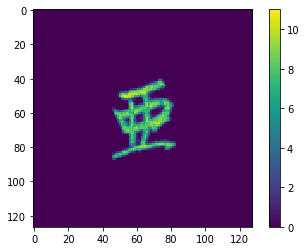

In [6]:
record = file_stream.readlist(','.join([
    'int:16', # Serial Sheet Number - [0]
    'uint:16', # JIS Character Code (JIS X 0208) - [1]
    '8*uint:8', # JIS Typical Reading (e.g. 'AI.MEDER') - [2:10]
    'int:32', # Serial Data Number - [10]
    '4*int:8', # - [11:15]
    '4*uint:16', # - [15:19]
    '2*int:8', # x and y - [19:21]
    'pad:272',
    'bytes:8128', # 16-graylevel (4-bit) image of 128 x 127 = 16256 pixels
    'pad:56',
]))

record_dict = {
    'JIS_CODE': record[1],
    'image_data': record[-1]
}

print(hex(record_dict['JIS_CODE']))

width = 128
height = 127
img = np.array(Image.frombytes('F', (width, height), record_dict['image_data'], 'bit', 4))
plt.imshow(img)
plt.colorbar()

In [7]:
print(type(record), len(record))
for idx, v in enumerate(record[:-1]):
    print(f'{idx} - {v}')

<class 'list'> 22
0 - 1
1 - 12321
2 - 65
3 - 46
4 - 84
5 - 83
6 - 85
7 - 71
8 - 85
9 - 32
10 - 1
11 - 0
12 - 0
13 - 0
14 - 0
15 - 0
16 - 0
17 - 8212
18 - 8310
19 - 0
20 - 0


In [8]:
total_samples = 0
record_count = {}

for filename in file_list:
    file_stream = bitstring.ConstBitStream(filename=filename)

    while True:
        try:
            record = file_stream.readlist(','.join([
                'int:16', # Serial Sheet Number - [0]
                'uint:16', # JIS Character Code (JIS X 0208) - [1]
                '8*uint:8', # JIS Typical Reading (e.g. 'AI.MEDER') - [2:10]
                'int:32', # Serial Data Number - [10]
                '4*int:8', # - [11:15]
                '4*uint:16', # - [15:19]
                '2*int:8', # x and y - [19:21]
                'pad:272',
                'bytes:8128', # 16-graylevel (4-bit) image of 128 x 127 = 16256 pixels
                'pad:56',
            ]))
        except:
            break
        
        total_samples += 1
        record_dict = {
            'JIS_CODE': record[1],
            'image_data': record[-1],
        }
        
        jis_code = hex(record_dict['JIS_CODE'])
        
#         jis_code = jis_code.upper()
        
        if jis_code in JIS0208.keys():
            unicode = JIS0208[jis_code]
    #         print('Unicode:', unicode)
            unicode_value = int(unicode, 0)
    #         print('Unicode value:', unicode_value)
            unicode_char = chr(unicode_value)
    #         print('Unicode char:', unicode_char)
        else:
            unicode_char = jis_code

        if unicode_char in record_count.keys():
            record_count[unicode_char] += 1
        else:
            record_count[unicode_char] = 1

In [9]:
total_samples

607200

In [10]:
len(record_count.keys())

3036

In [11]:
record_count

{'亜': 200,
 '唖': 200,
 '娃': 200,
 '阿': 200,
 '哀': 200,
 '愛': 200,
 '挨': 200,
 '姶': 200,
 '逢': 200,
 '葵': 200,
 '茜': 200,
 '穐': 200,
 '悪': 200,
 '握': 200,
 '渥': 200,
 'あ': 200,
 '旭': 200,
 '葦': 200,
 '芦': 200,
 '鯵': 200,
 '梓': 200,
 '圧': 200,
 '斡': 200,
 '扱': 200,
 '宛': 200,
 '姐': 200,
 '虻': 200,
 '飴': 200,
 '絢': 200,
 '綾': 200,
 '鮎': 200,
 'い': 200,
 '或': 200,
 '粟': 200,
 '袷': 200,
 '安': 200,
 '庵': 200,
 '按': 200,
 '暗': 200,
 '案': 200,
 '闇': 200,
 '鞍': 200,
 '杏': 200,
 '以': 200,
 '伊': 200,
 '位': 200,
 '依': 200,
 'う': 200,
 '偉': 200,
 '囲': 200,
 '夷': 200,
 '委': 200,
 '威': 200,
 '尉': 200,
 '惟': 200,
 '意': 200,
 '慰': 200,
 '易': 200,
 '椅': 200,
 '為': 200,
 '畏': 200,
 '異': 200,
 '移': 200,
 '維': 200,
 '緯': 200,
 '胃': 200,
 '萎': 200,
 '衣': 200,
 '謂': 200,
 '違': 200,
 '遺': 200,
 '医': 200,
 '井': 200,
 '亥': 200,
 '域': 200,
 '育': 200,
 '郁': 200,
 '磯': 200,
 '一': 200,
 '壱': 200,
 '溢': 200,
 '逸': 200,
 '稲': 200,
 '茨': 200,
 '芋': 200,
 '鰯': 200,
 '允': 200,
 '印': 200,
 '咽': 200,
 '員': 200,
 '因': 200,

In [13]:
csv_filename = 'classes.tsv'
with open(csv_filename, mode='w', encoding='utf-8') as f:
    f.write('class\tnum_samples\n')
    for k in record_count.keys():
        log_str = f'{k}\t{record_count[k]}\n'
        f.write(log_str)
# sort classes
pd_df = pd.read_csv(csv_filename, encoding='utf-8', sep='\t')
pd_df = pd_df.sort_values(['class'])
pd_df.to_csv(csv_filename, encoding='utf-8', index=False, sep='\t')

## Extract to images

In [22]:
from tqdm import tqdm

In [23]:
filename

'ETL9G_50'

In [25]:
file_size = os.path.getsize(filename)
file_size

99568656

In [26]:
record_length = 8199 # bytes (8 bits per byte)

In [27]:
file_size / record_length

12144.0

In [32]:
total_samples = 0
record_count = {}

record_length = 8199 # bytes (8 bits per byte)

start_time = time.time()

for file_idx, filename in enumerate(file_list):
    print(f'{file_idx+1}/{len(file_list)}: Loading {filename}...')
    
    file_size = os.path.getsize(filename)
    num_samples = int(file_size / record_length)

    file_stream = bitstring.ConstBitStream(filename=filename)

    for _ in tqdm(range(num_samples)):
        record = file_stream.readlist(','.join([
            'int:16', # Serial Sheet Number - [0]
            'uint:16', # JIS Character Code (JIS X 0208) - [1]
            '8*uint:8', # JIS Typical Reading (e.g. 'AI.MEDER') - [2:10]
            'int:32', # Serial Data Number - [10]
            '4*int:8', # - [11:15]
            '4*uint:16', # - [15:19]
            '2*int:8', # x and y - [19:21]
            'pad:272',
            'bytes:8128', # 16-graylevel (4-bit) image of 128 x 127 = 16256 pixels
            'pad:56',
        ]))
        
        total_samples += 1
        record_dict = {
            'JIS_CODE': record[1],
            'image_data': record[-1],
        }
        
        jis_code = hex(record_dict['JIS_CODE'])
        
        if jis_code in JIS0208.keys():
            # get the unicode hex string
            unicode = JIS0208[jis_code]
            # convert to int hex value
            unicode_value = int(unicode, 0)
            # decode into char
            unicode_char = chr(unicode_value)
        else:
            unicode_char = jis_code

        if unicode_char in record_count.keys():
            record_count[unicode_char] += 1
        else:
            record_count[unicode_char] = 1
            
        save_dir = 'ETL9G_IMG'
        img_filename = f'{unicode_char}_{str(record_count[unicode_char]).zfill(3)}.png'
        img_dir = f'{save_dir}/{unicode_char}'
        if not os.path.exists(img_dir):
            os.makedirs(img_dir)
        img_path = f'{img_dir}/{img_filename}'
        
        if os.path.exists(img_path):
            continue

        width = 128
        height = 127
        np_img = np.array(Image.frombytes('F', (width, height), record_dict['image_data'], 'bit', 4))
        scaled_img = (np_img * 17).astype(np.uint8)
        pil_img = Image.fromarray(scaled_img)
        pil_img.save(img_path)
    
    total_time = time.time() - start_time
    avg_time = total_time / (file_idx + 1)
    remain_time = (len(file_list) - file_idx - 1) * avg_time
    
    print(f'total_time: {total_time:.2f}s, avg_time: {avg_time:.2f}s, remain_time: {remain_time:.2f}s')

1/50: Loading ETL9G_01...


100%|███████████████████████████████████████████████████████████████████████████| 12144/12144 [00:43<00:00, 277.19it/s]


total_time: 43.85s, avg_time: 43.85s, remain_time: 2148.43s
2/50: Loading ETL9G_02...


100%|███████████████████████████████████████████████████████████████████████████| 12144/12144 [00:57<00:00, 209.61it/s]


total_time: 101.80s, avg_time: 50.90s, remain_time: 2443.24s
3/50: Loading ETL9G_03...


100%|███████████████████████████████████████████████████████████████████████████| 12144/12144 [01:10<00:00, 171.37it/s]


total_time: 172.69s, avg_time: 57.56s, remain_time: 2705.51s
4/50: Loading ETL9G_04...


100%|███████████████████████████████████████████████████████████████████████████| 12144/12144 [01:14<00:00, 162.33it/s]


total_time: 247.52s, avg_time: 61.88s, remain_time: 2846.45s
5/50: Loading ETL9G_05...


100%|███████████████████████████████████████████████████████████████████████████| 12144/12144 [01:21<00:00, 149.10it/s]


total_time: 328.99s, avg_time: 65.80s, remain_time: 2960.92s
6/50: Loading ETL9G_06...


100%|███████████████████████████████████████████████████████████████████████████| 12144/12144 [01:21<00:00, 149.67it/s]


total_time: 410.14s, avg_time: 68.36s, remain_time: 3007.71s
7/50: Loading ETL9G_07...


100%|███████████████████████████████████████████████████████████████████████████| 12144/12144 [01:27<00:00, 139.25it/s]


total_time: 497.37s, avg_time: 71.05s, remain_time: 3055.29s
8/50: Loading ETL9G_08...


100%|███████████████████████████████████████████████████████████████████████████| 12144/12144 [01:23<00:00, 144.58it/s]


total_time: 581.39s, avg_time: 72.67s, remain_time: 3052.27s
9/50: Loading ETL9G_09...


100%|███████████████████████████████████████████████████████████████████████████| 12144/12144 [01:22<00:00, 146.78it/s]


total_time: 664.15s, avg_time: 73.79s, remain_time: 3025.56s
10/50: Loading ETL9G_10...


100%|███████████████████████████████████████████████████████████████████████████| 12144/12144 [01:36<00:00, 125.95it/s]


total_time: 760.61s, avg_time: 76.06s, remain_time: 3042.45s
11/50: Loading ETL9G_11...


100%|███████████████████████████████████████████████████████████████████████████| 12144/12144 [01:26<00:00, 139.77it/s]


total_time: 847.52s, avg_time: 77.05s, remain_time: 3004.86s
12/50: Loading ETL9G_12...


100%|███████████████████████████████████████████████████████████████████████████| 12144/12144 [01:31<00:00, 132.13it/s]


total_time: 939.46s, avg_time: 78.29s, remain_time: 2974.96s
13/50: Loading ETL9G_13...


100%|███████████████████████████████████████████████████████████████████████████| 12144/12144 [01:27<00:00, 138.68it/s]


total_time: 1027.06s, avg_time: 79.00s, remain_time: 2923.17s
14/50: Loading ETL9G_14...


100%|███████████████████████████████████████████████████████████████████████████| 12144/12144 [01:25<00:00, 141.22it/s]


total_time: 1113.09s, avg_time: 79.51s, remain_time: 2862.23s
15/50: Loading ETL9G_15...


100%|███████████████████████████████████████████████████████████████████████████| 12144/12144 [01:38<00:00, 123.30it/s]


total_time: 1211.60s, avg_time: 80.77s, remain_time: 2827.07s
16/50: Loading ETL9G_16...


100%|███████████████████████████████████████████████████████████████████████████| 12144/12144 [01:22<00:00, 147.55it/s]


total_time: 1293.93s, avg_time: 80.87s, remain_time: 2749.61s
17/50: Loading ETL9G_17...


100%|███████████████████████████████████████████████████████████████████████████| 12144/12144 [01:26<00:00, 140.68it/s]


total_time: 1380.28s, avg_time: 81.19s, remain_time: 2679.37s
18/50: Loading ETL9G_18...


100%|███████████████████████████████████████████████████████████████████████████| 12144/12144 [01:21<00:00, 149.30it/s]


total_time: 1461.65s, avg_time: 81.20s, remain_time: 2598.48s
19/50: Loading ETL9G_19...


100%|███████████████████████████████████████████████████████████████████████████| 12144/12144 [01:32<00:00, 131.26it/s]


total_time: 1554.20s, avg_time: 81.80s, remain_time: 2535.81s
20/50: Loading ETL9G_20...


100%|███████████████████████████████████████████████████████████████████████████| 12144/12144 [01:40<00:00, 121.34it/s]


total_time: 1654.31s, avg_time: 82.72s, remain_time: 2481.47s
21/50: Loading ETL9G_21...


100%|███████████████████████████████████████████████████████████████████████████| 12144/12144 [01:34<00:00, 128.86it/s]


total_time: 1748.58s, avg_time: 83.27s, remain_time: 2414.71s
22/50: Loading ETL9G_22...


100%|███████████████████████████████████████████████████████████████████████████| 12144/12144 [01:44<00:00, 116.23it/s]


total_time: 1853.11s, avg_time: 84.23s, remain_time: 2358.50s
23/50: Loading ETL9G_23...


100%|███████████████████████████████████████████████████████████████████████████| 12144/12144 [01:41<00:00, 119.16it/s]


total_time: 1955.06s, avg_time: 85.00s, remain_time: 2295.06s
24/50: Loading ETL9G_24...


100%|███████████████████████████████████████████████████████████████████████████| 12144/12144 [01:35<00:00, 127.67it/s]


total_time: 2050.21s, avg_time: 85.43s, remain_time: 2221.06s
25/50: Loading ETL9G_25...


100%|███████████████████████████████████████████████████████████████████████████| 12144/12144 [01:43<00:00, 117.13it/s]


total_time: 2153.92s, avg_time: 86.16s, remain_time: 2153.92s
26/50: Loading ETL9G_26...


100%|███████████████████████████████████████████████████████████████████████████| 12144/12144 [01:32<00:00, 131.32it/s]


total_time: 2246.43s, avg_time: 86.40s, remain_time: 2073.63s
27/50: Loading ETL9G_27...


100%|███████████████████████████████████████████████████████████████████████████| 12144/12144 [01:29<00:00, 135.00it/s]


total_time: 2336.42s, avg_time: 86.53s, remain_time: 1990.29s
28/50: Loading ETL9G_28...


100%|███████████████████████████████████████████████████████████████████████████| 12144/12144 [01:31<00:00, 133.17it/s]


total_time: 2427.64s, avg_time: 86.70s, remain_time: 1907.43s
29/50: Loading ETL9G_29...


100%|███████████████████████████████████████████████████████████████████████████| 12144/12144 [01:30<00:00, 134.45it/s]


total_time: 2517.99s, avg_time: 86.83s, remain_time: 1823.37s
30/50: Loading ETL9G_30...


100%|███████████████████████████████████████████████████████████████████████████| 12144/12144 [01:45<00:00, 115.17it/s]


total_time: 2623.44s, avg_time: 87.45s, remain_time: 1748.96s
31/50: Loading ETL9G_31...


100%|███████████████████████████████████████████████████████████████████████████| 12144/12144 [01:39<00:00, 121.71it/s]


total_time: 2723.25s, avg_time: 87.85s, remain_time: 1669.09s
32/50: Loading ETL9G_32...


100%|███████████████████████████████████████████████████████████████████████████| 12144/12144 [01:25<00:00, 142.80it/s]


total_time: 2808.33s, avg_time: 87.76s, remain_time: 1579.69s
33/50: Loading ETL9G_33...


100%|███████████████████████████████████████████████████████████████████████████| 12144/12144 [01:41<00:00, 119.58it/s]


total_time: 2909.93s, avg_time: 88.18s, remain_time: 1499.06s
34/50: Loading ETL9G_34...


100%|███████████████████████████████████████████████████████████████████████████| 12144/12144 [01:35<00:00, 127.24it/s]


total_time: 3005.40s, avg_time: 88.39s, remain_time: 1414.31s
35/50: Loading ETL9G_35...


100%|███████████████████████████████████████████████████████████████████████████| 12144/12144 [01:42<00:00, 118.87it/s]


total_time: 3107.61s, avg_time: 88.79s, remain_time: 1331.83s
36/50: Loading ETL9G_36...


100%|███████████████████████████████████████████████████████████████████████████| 12144/12144 [01:32<00:00, 130.79it/s]


total_time: 3200.51s, avg_time: 88.90s, remain_time: 1244.64s
37/50: Loading ETL9G_37...


100%|███████████████████████████████████████████████████████████████████████████| 12144/12144 [01:29<00:00, 135.99it/s]


total_time: 3289.83s, avg_time: 88.91s, remain_time: 1155.89s
38/50: Loading ETL9G_38...


100%|███████████████████████████████████████████████████████████████████████████| 12144/12144 [01:43<00:00, 117.74it/s]


total_time: 3393.02s, avg_time: 89.29s, remain_time: 1071.48s
39/50: Loading ETL9G_39...


100%|███████████████████████████████████████████████████████████████████████████| 12144/12144 [01:43<00:00, 117.31it/s]


total_time: 3496.59s, avg_time: 89.66s, remain_time: 986.22s
40/50: Loading ETL9G_40...


100%|███████████████████████████████████████████████████████████████████████████| 12144/12144 [01:54<00:00, 106.36it/s]


total_time: 3610.81s, avg_time: 90.27s, remain_time: 902.70s
41/50: Loading ETL9G_41...


100%|███████████████████████████████████████████████████████████████████████████| 12144/12144 [01:48<00:00, 112.44it/s]


total_time: 3718.83s, avg_time: 90.70s, remain_time: 816.33s
42/50: Loading ETL9G_42...


100%|███████████████████████████████████████████████████████████████████████████| 12144/12144 [01:44<00:00, 116.36it/s]


total_time: 3823.22s, avg_time: 91.03s, remain_time: 728.23s
43/50: Loading ETL9G_43...


100%|███████████████████████████████████████████████████████████████████████████| 12144/12144 [01:40<00:00, 120.64it/s]


total_time: 3923.93s, avg_time: 91.25s, remain_time: 638.78s
44/50: Loading ETL9G_44...


100%|███████████████████████████████████████████████████████████████████████████| 12144/12144 [01:39<00:00, 122.09it/s]


total_time: 4023.43s, avg_time: 91.44s, remain_time: 548.65s
45/50: Loading ETL9G_45...


100%|███████████████████████████████████████████████████████████████████████████| 12144/12144 [01:50<00:00, 110.05it/s]


total_time: 4133.80s, avg_time: 91.86s, remain_time: 459.31s
46/50: Loading ETL9G_46...


100%|███████████████████████████████████████████████████████████████████████████| 12144/12144 [01:43<00:00, 117.00it/s]


total_time: 4237.62s, avg_time: 92.12s, remain_time: 368.49s
47/50: Loading ETL9G_47...


100%|███████████████████████████████████████████████████████████████████████████| 12144/12144 [01:44<00:00, 116.35it/s]


total_time: 4342.06s, avg_time: 92.38s, remain_time: 277.15s
48/50: Loading ETL9G_48...


100%|███████████████████████████████████████████████████████████████████████████| 12144/12144 [01:43<00:00, 117.53it/s]


total_time: 4445.42s, avg_time: 92.61s, remain_time: 185.23s
49/50: Loading ETL9G_49...


100%|███████████████████████████████████████████████████████████████████████████| 12144/12144 [01:30<00:00, 134.26it/s]


total_time: 4535.90s, avg_time: 92.57s, remain_time: 92.57s
50/50: Loading ETL9G_50...


100%|███████████████████████████████████████████████████████████████████████████| 12144/12144 [01:56<00:00, 103.81it/s]


total_time: 4652.93s, avg_time: 93.06s, remain_time: 0.00s


In [18]:
img_path

'ETL9G_IMG/腕/腕_200.png'

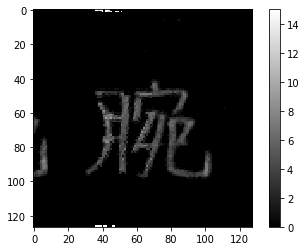

In [29]:
np_img = np.array(Image.frombytes('F', (width, height), record_dict['image_data'], 'bit', 4))
plt.imshow(np_img, cmap='gray')
plt.colorbar()

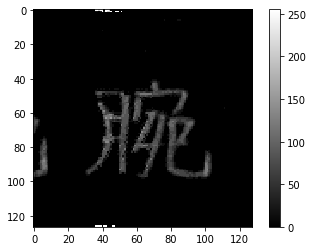

In [30]:
scaled_img = (np_img * 17).astype(np.uint8)
plt.imshow(scaled_img, cmap='gray')
plt.colorbar()

In [31]:
pil_img = Image.fromarray(scaled_img)
pil_img.save(img_path)
img_path

'ETL9G_IMG/腕/腕_200.png'